# Cliff walking experiment by Rodi Laanen, Cognitive Modelling 2021-2022

In order to run this Jupyter Notebook, open the link to this Jupyter Notebook in Google Colab. Another option would be to run this Jupyter Notebook on your local machine. If we want to run the notebook on a local machine, we will need a version of Python 3 and Jupyter Notebook installed. This could be done by installing Anaconda. 

In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

# Building the cliff world
First, we need to build a version of the cliff world (Sutton & Barto, 2018). However, before we do that, we want to emphasise that we opt for a modular design. This means that we try to avoid hard coded values and, thus, leave more space to the user to explore the cliff-walking experiment. The cliff world contains four different states: S represents the start state, G represents the goals state, the cliff is presented by a couple of C's and the remaining walking paths are indicated with #. Let's build this world and print it out, in order to get a better overview of the world:

In [2]:
rows = 4   #number of rows
columns = 12   #number of columns 

cliffWorld = np.zeros([rows, columns], dtype = object)   #save the world in a numpy.array
for i in range(rows):
    for j in range(columns):
        if(i== rows - 1 and j == 0):   #left bottom corner is the start state
            cliffWorld[i][j] = "S"
        elif(i == rows - 1 and j == columns - 1):   #right bottom corner is the goal state
            cliffWorld[i][j] = "G"
        elif(i == rows - 1):   #the remaining of the bottom row represents the cliff
            cliffWorld[i][j] = "C"
        else:   #the remaining rows of the cliff world are normal walking paths
            cliffWorld[i][j] = "#"

print(cliffWorld)

[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['S' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']]


# Actions
Another imporant aspect of the cliff-walking experiment is that our agent needs to be able to move through the environment. Therefore, we will give our agent the ability to perform four different actions stored in the list called actions: move up, move down, move left and move right. Since the movements represents a core component for our agent, we will wrap the different moves in the following function:



In [3]:
actions = ["up", "down", "left", "right"]

def moveAgent(action, position):
    if(action == actions[0] and position[0] != 0): #action up and check if the current agent position is not the upper row  
        position[0] -= 1   #the agent moves a position up
    if(action == actions[1] and position[0] != rows - 1):   #action down and check if current agent position is not bottom row
        position[0] += 1   #the agent moves a position down
    if(action == actions[2] and position[1] != 0):   #action left and check if current agent position is not left most column
        position[1] -= 1   #the agent moves a position to the left
    if(action == actions[3] and position[1] != columns -1):   #action right and check if current agent position is not right most column
        position[1] += 1   #the agent moves a position to the right
    return position

# Reward function
The reward function is one of the core components of reinforcement learning (RL) (Sutton & Barto, 2018). In this cliff world, an agent will receive a penalty of -100 for falling of the cliff (e.g. when the agent is on a C state). In all other states, the agent will receive a reward of -1.

In [4]:
def getReward(pos1, pos2, reward):
    if(cliffWorld[pos2[0]][pos2[1]] == "C"):   #if next position (i.e. pos2) is a cliff state
        reward = -100
    else:   #next position is not a cliff state
        reward  = -1
    return reward

# Reinforcement learning methods
In this part of the code, we will focus on implementing three different RL methods. First, we define two action selection methods: e-greedy and softmax. Then, we will implement Q-learning (Watkins & Dayan, 1992), Sarsa (Rummery & Niranjan, 1994) and Expected Sarsa (van Seijen et al., 2009). We will need these algorithms in order to assess the difference between on-policy and off-policy learning with the aid of the cliff walking problem. 

In [5]:
def eGreedy(epsilon, actions, QVals):
    if(np.random.uniform(0,1) < epsilon):
        actionIdx = random.randint(len(actions))    #pick one of the four actions at random
        action = actions[actionIdx]
    else:
        actionIdx = np.argmax(QVals)    #pick the action which yields the highest Q value in combination with the current state
        action = actions[actionIdx]
    return action, actionIdx
        
def softmax(beta, actions, QVals):
        PVals = np.exp(QVals/beta)/np.sum(np.exp(QVals/beta))   #calculate probability of every current state-action pair
        actionIdx = np.random.choice(len(actions), p = PVals)   #choose an action at random taking in consideration the weight 
        action = actions[actionIdx]                             # of each current state action pair
        return action, actionIdx

# Q-learning

In [6]:
def QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions):
    Q = np.zeros([rows*columns, len(actions)])   #initialize Q-matrix (|S| x |A|)
    sumRewardArr = []   #array to save the obtained reward for each episode
    reward = 0   #initialize reward parameter
    for i in range(episodes):
        state = [rows - 1, 0]   #initialize start state (e.g. the bottom left corner of the cliff world)
        sumRewards = 0   #reset the total obtained reward per episode parameter
        
        #an episode terminates if the agent reached the goal state (e.g. G) or falls of the cliff (e.g. C)
        while (cliffWorld[state[0]][state[1]] != "G") and (cliffWorld[state[0]][state[1]] != "C"):
            copy_state = np.copy(state)
            QVals = Q[state[0]*columns+state[1]][:]   #determine the expectations for the current state action pairs (4 in total)
            if(method == "egreedy"):   #e-greedy action selection
                action, actionIdx = eGreedy(epsilon, actions, QVals)
            else:   #softmax action selection
                action, actionIdx = softmax(beta, actions, QVals)
            nextState = moveAgent(action, copy_state)   #determine the next state by performing the chosen action
            reward = getReward(state, nextState, reward)   #get reward based upon action
            sumRewards += reward   #sum this new reward with the already obtained rewards
            #update the Q table according to the Q-learning update function (off-policy)
            Q[state[0]*columns+state[1]][actionIdx] += alpha * (reward + gamma * np.max(Q[nextState[0]*columns+nextState[1]][:]) - Q[state[0]*columns+state[1]][actionIdx])
            state = nextState
        sumRewardArr.append(sumRewards)   #save the total obtained reward for the finished episode
    return sumRewardArr

# Sarsa

In [7]:
def Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions):
    Q = np.zeros([rows*columns, len(actions)])   #initialize Q-matrix (|S| x |A|)
    sumRewardArr = []    #array to save the obtained reward for each episode
    reward = 0   #initialize reward parameter
    for i in range(episodes):
        state = [rows - 1, 0]   #initialize start state (e.g. the bottom left corner of the cliff world)
        sumRewards = 0   #reset the total obtaind reward per episode parameter
        QVals = Q[state[0]*columns+state[1]][:]   #determine the expectations for the current-state action pairs (4 in total)
        if(method == "egreedy"):   #e-greedy action selection   
            action, actionIdx = eGreedy(epsilon, actions, QVals)
        else:   #softmax action selection
            action, actionIdx = softmax(beta, actions, QVals)
        
        #an episode terminates if the agent reached the goal state (e.g. G) or falls of the cliff (e.g. C)
        while (cliffWorld[state[0]][state[1]] != "G") and (cliffWorld[state[0]][state[1]] != "C"):
            copy_state = np.copy(state)
            nextState = moveAgent(action, copy_state)   #determine the next state by performing the chosen action
            reward = getReward(state, nextState, reward)   #get reward based upon action
            sumRewards += reward   #sum this new reward with the already obtained rewards
            
            QVals2 = Q[nextState[0]*columns+nextState[1]][:]   #determine the expectations for the next-state action pairs (4 in total)
            if(method == "egreedy"):
                nextaction, nextactionIdx = eGreedy(epsilon, actions, QVals2)
            else:
                nextaction, nextactionIdx = softmax(beta, actions, QVals2)
            #update the Q table according to the Sarsa update function (on-policy)
            Q[state[0]*columns+state[1]][actionIdx] += alpha * (reward + gamma * Q[nextState[0]*columns+nextState[1]][nextactionIdx] - Q[state[0]*columns+state[1]][actionIdx])
    
            state = nextState
            action = nextaction
            actionIdx = nextactionIdx
        sumRewardArr.append(sumRewards)   #save the total obtained reward for the finished episode 
    return sumRewardArr

# Expected Sarsa

In [8]:
def expectedSarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions):
    Q = np.zeros([rows*columns, len(actions)])   #initialize Q-matrix (|States| x |Actions|)
    sumRewardArr = []   #array to save the obtained erward for each episode
    reward = 0   #initialize reward parameter 
    for i in range(episodes):
        state = [rows - 1, 0]   #initialize start state (e.g. the bottom left corner of the cliff world)
        sumRewards = 0   #reset the total obtained reward per episode parameter
        
        #an episode terminates if the agent reached the goal state (e.g. G) or falls of the cliff (.e.g. C)
        while (cliffWorld[state[0]][state[1]] != "G") and (cliffWorld[state[0]][state[1]] != "C"):
            QVals = Q[state[0]*columns+state[1]][:]   #determine the expectations for the current-state action pairs (4 in total)
            if(method == "egreedy"):   #e-greedy action selection
                action, actionIdx = eGreedy(epsilon, actions, QVals)
            else:   #softmax action selection
                action, actionIdx = softmax(beta, actions, QVals)
            copy_state = np.copy(state)
            nextState = moveAgent(action, copy_state)   #determine the next state by performing the chosen action
            reward = getReward(state, nextState, reward)   #get reward based upon action
            sumRewards += reward
                
            exp_q = 0   #reset expected 
            QVals2 = Q[nextState[0]*columns+nextState[1]][:]   #determine the expectations for the next-SA pairs (4 in total)
            if(method == "egreedy"):
                best = [i for i in range(len(actions)) if QVals2[i]==np.max(QVals2)]   #count the number of highest next-SA pairs
                nonGreedyActionsProb = epsilon/len(actions)   #chance to pick a random action = e/|A|
                greedyActionsProb = (1-epsilon)/len(best) + nonGreedyActionsProb   #chance to pick greedy action=
                                                                               #(1-e)/# highest next SA-pairs  + e/|A|
                for act in range(len(actions)):   #determine probability for each next-SA pair according to e-greedy policy                                 
                    if(Q[nextState[0]*columns+nextState[1]][act]==np.max(QVals2)):   #greedy probability
                        exp_q += Q[nextState[0]*columns+nextState[1]][act] * greedyActionsProb
                    else:   #non greedy probability
                        exp_q += Q[nextState[0]*columns+nextState[1]][act] *nonGreedyActionsProb
            else:
                PVals = np.exp(beta * QVals2)/np.sum(np.exp(beta * QVals2))   #determine the probabilities of each next-SA pair
                for act in range(len(actions)):   #determine probability for each next-SA pair according to softmax policy 
                    exp_q += Q[nextState[0]*columns+nextState[1]][act] * PVals[act]
                    
            #update the Q table according to the Expected Sarsa update function (on-policy)
            Q[state[0]*columns+state[1]][actionIdx] += alpha * (reward + gamma * exp_q - Q[state[0]*columns+state[1]][actionIdx])
    
            state = nextState
        sumRewardArr.append(sumRewards)
    return sumRewardArr

# Experiments
In the last section of the code, we will conduct several experiments regarding the cliff walking problem. 

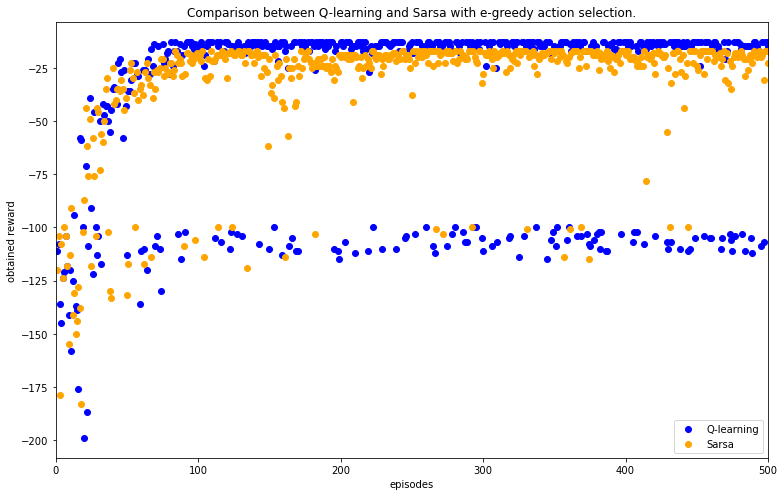

In [9]:
alpha = 0.5   #learning rate
beta = 1.0   #temperature
gamma = 1.0   #discount factor
epsilon = 0.1   #parameter for e-greedy action selection
method = "egreedy"
episodes = 500

QrewardArrE, SrewardArrE = [], []   #initialise arrays to save obtained reward per episode (Egreedy)
QrewardArrE = QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
SrewardArrE = Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
epArr = [i+1 for i in range(episodes)]   #generate an array with all the episode numbers

#generate the plot
fig, (ax1) = plt.subplots(1,1, figsize = (11,7))
p1 = ax1.scatter(epArr, QrewardArrE, color = "blue")
p2 = ax1.scatter(epArr, SrewardArrE, color = "orange")
plt.xlim([0, episodes])
ax1.set_title("Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax1.set_xlabel("episodes")
ax1.set_ylabel("obtained reward")
ax1.legend([p1, p2], ["Q-learning", "Sarsa"])
plt.tight_layout()
#plt.savefig('Figure1.pdf') 
plt.show()

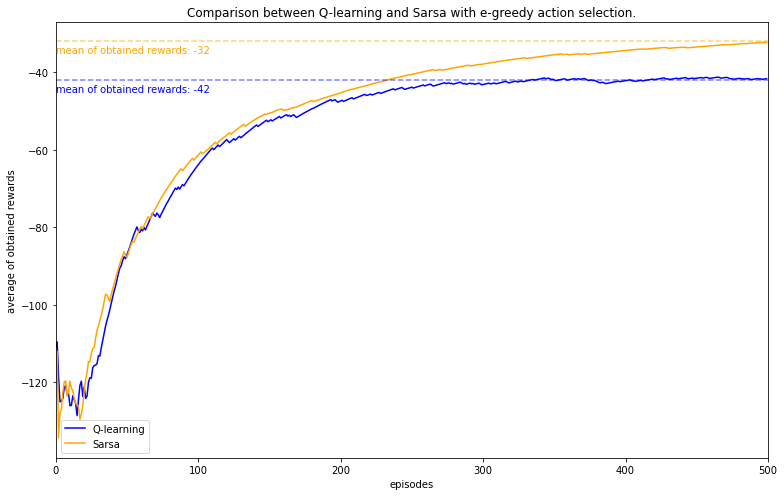

In [10]:
sumQreward, sumSreward = 0, 0   #keep track of the current sum of obtained rewards
avgQrewardArrE, avgSrewardArrE = [], []   #initialise arrays to hold the average of obtained rewards (Egreedy)

for i in range(episodes):
    sumQreward += QrewardArrE[i]   #add the new reward of the current episode to the sum of rewards from the previous episodes
    sumSreward += SrewardArrE[i]   #
    avgQrewardArrE.append(sumQreward/ (i+1))   #calculate the new average based on the sum of rewards/number of finished episodes
    avgSrewardArrE.append(sumSreward/ (i+1))
    
meanQrewardArrE = round(np.mean(QrewardArrE))   #calculate the total mean of all the rewards (Egreedy)
meanSrewardArrE = round(np.mean(SrewardArrE))

#generate the plot
fig, (ax1) = plt.subplots(1,1, figsize = (11,7))
p1, = ax1.plot(avgQrewardArrE, color = "blue")
p2, = ax1.plot(avgSrewardArrE, color = "orange")
ax1.axhline(y=meanQrewardArrE,  color="blue",linestyle='dashed', alpha = 0.5)
ax1.axhline(y=meanSrewardArrE, color="orange", linestyle = "dashed", alpha = 0.5)
plt.xlim([0, episodes])
ax1.set_title("Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax1.set_xlabel("episodes")
ax1.set_ylabel("average of obtained rewards")
ax1.legend([p1, p2], ["Q-learning", "Sarsa"])
ax1.text(0.5, meanQrewardArrE - 3, "mean of obtained rewards: " + str(meanQrewardArrE), color = "blue")
ax1.text(0.5, meanSrewardArrE - 3, "mean of obtained rewards: " + str(meanSrewardArrE), color = "orange")
plt.tight_layout()
#plt.savefig('Figure2.pdf') 
plt.show()

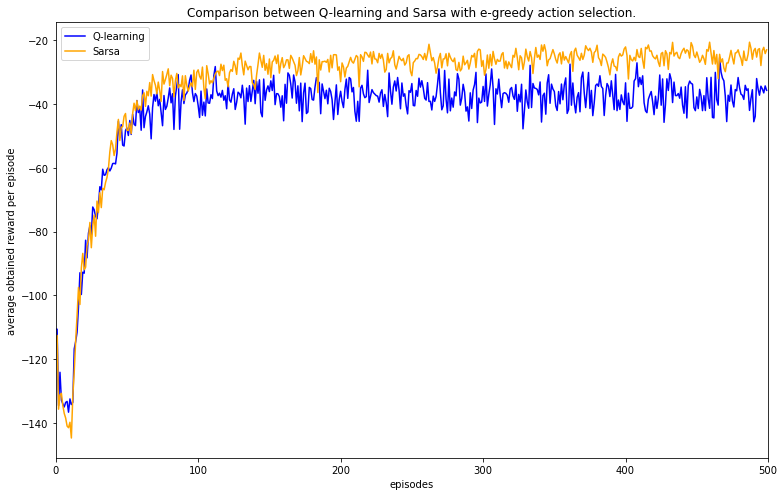

In [11]:
runs = 100   #this can take some minutes to run
QrunArrE, SrunArrE = [], []   #initialise arrays to hold the obtained rewards for all episodes per run (Egreedy)
avgQrunE, avgSrunE = [], []   #initialise arrays to hold the average reward per episode averaged over all runs (Egreedy)


for i in range(runs):
    QrewardArr, SrewardArr = [], []   #reset arrays to hold the obtained reward per episode
    QrewardArr = QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
    SrewardArr = Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
    QrunArrE.append(QrewardArr)
    SrunArrE.append(SrewardArr)

QrunArrE = np.array(QrunArrE)   #convert to numpy.array
SrunArrE = np.array(SrunArrE)

for i in range(episodes):
    avgQrunE.append(np.mean(QrunArrE[:,i]))   #calculate average reward per episode averaged over all runs (Egreedy)
    avgSrunE.append(np.mean(SrunArrE[:,i]))

#generate the plot 
fig, (ax1) = plt.subplots(1,1, figsize = (11,7))
p1, = ax1.plot(avgQrunE, color = "blue")
p2, = ax1.plot(avgSrunE, color = "orange")
plt.xlim([0, episodes])
ax1.set_title("Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax1.set_xlabel("episodes")
ax1.set_ylabel("average obtained reward per episode")
ax1.legend([p1, p2], ["Q-learning", "Sarsa"])
plt.tight_layout()
#plt.savefig('Figure3.pdf')
plt.show()

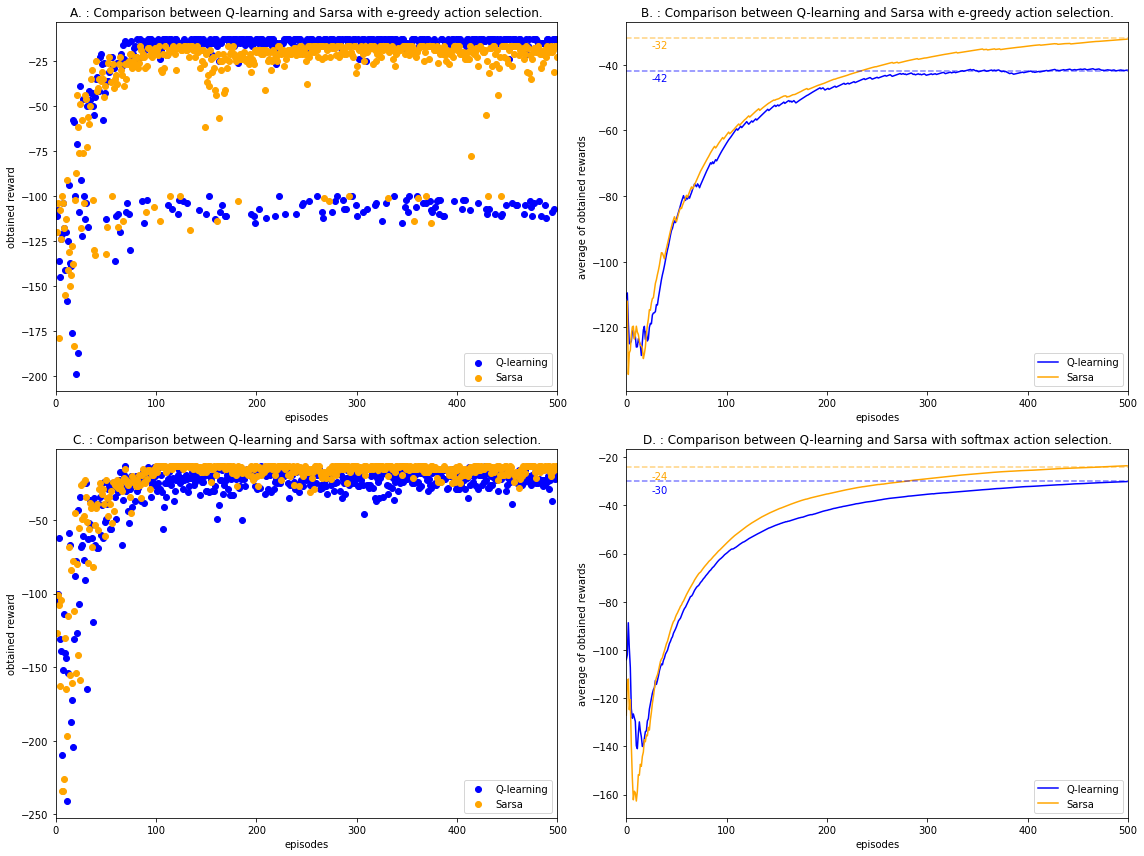

In [12]:
method = "softmax"

sumQreward, sumSreward = 0, 0   #keep track of the current sum of obtained rewards
avgQrewardArrS, avgSrewardArrS = [], []   #initialise arrays to hold the average of obtained rewards (Softmax)

QrewardArrS = QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
SrewardArrS = Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)

for i in range(episodes):
    sumQreward += QrewardArrS[i]   #add the new reward of the current episode to the sum of rewards from the previous episodes
    sumSreward += SrewardArrS[i]
    avgQrewardArrS.append(sumQreward/ (i+1)) #calculate the new average based on the sum of rewards/number of finished episodes
    avgSrewardArrS.append(sumSreward/ (i+1))
    
meanQrewardArrS = round(np.mean(QrewardArrS)) #calculate the total mean of all the rewards (Softmax)
meanSrewardArrS = round(np.mean(SrewardArrS))

#generate four plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (16,12))
p1 = ax1.scatter(epArr, QrewardArrE, color = "blue")
p2 = ax1.scatter(epArr, SrewardArrE, color = "orange")
p3, = ax2.plot(avgQrewardArrE, color = "blue")
p4, = ax2.plot(avgSrewardArrE, color = "orange")
p5 = ax3.scatter(epArr, QrewardArrS, color = "blue")
p6 = ax3.scatter(epArr, SrewardArrS, color = "orange")
p7, = ax4.plot(avgQrewardArrS, color = "blue")
p8, = ax4.plot(avgSrewardArrS, color = "orange")
ax2.axhline(y=meanQrewardArrE,  color="blue",linestyle='dashed', alpha = 0.5)
ax2.axhline(y=meanSrewardArrE, color="orange", linestyle = "dashed", alpha = 0.5)
ax4.axhline(y=meanQrewardArrS,  color="blue",linestyle='dashed', alpha = 0.5)
ax4.axhline(y=meanSrewardArrS, color="orange", linestyle = "dashed", alpha = 0.5)
ax1.set_xlim([0, episodes])
ax2.set_xlim([0, episodes])
ax3.set_xlim([0, episodes])
ax4.set_xlim([0, episodes])
ax1.set_title("A. : Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax1.set_xlabel("episodes")
ax1.set_ylabel("obtained reward")
ax2.set_title("B. : Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax2.set_xlabel("episodes")
ax2.set_ylabel("average of obtained rewards")
ax3.set_title("C. : Comparison between Q-learning and Sarsa with softmax action selection.")
ax3.set_xlabel("episodes")
ax3.set_ylabel("obtained reward")
ax4.set_title("D. : Comparison between Q-learning and Sarsa with softmax action selection.")
ax4.set_xlabel("episodes")
ax4.set_ylabel("average of obtained rewards")
ax1.legend([p1, p2], ["Q-learning", "Sarsa"])
ax2.legend([p3, p4], ["Q-learning", "Sarsa"])
ax3.legend([p5, p6], ["Q-learning", "Sarsa"])
ax4.legend([p7, p8], ["Q-learning", "Sarsa"])
ax2.text(25, meanQrewardArrE - 3, str(meanQrewardArrE), color = "blue")
ax2.text(25, meanSrewardArrE - 3, str(meanSrewardArrE), color = "orange")
ax4.text(25, meanQrewardArrS - 5, str(meanQrewardArrS), color = "blue")
ax4.text(25, meanSrewardArrS - 5, str(meanSrewardArrS), color = "orange")
plt.tight_layout()
#plt.savefig('Figure4.pdf')
plt.show()

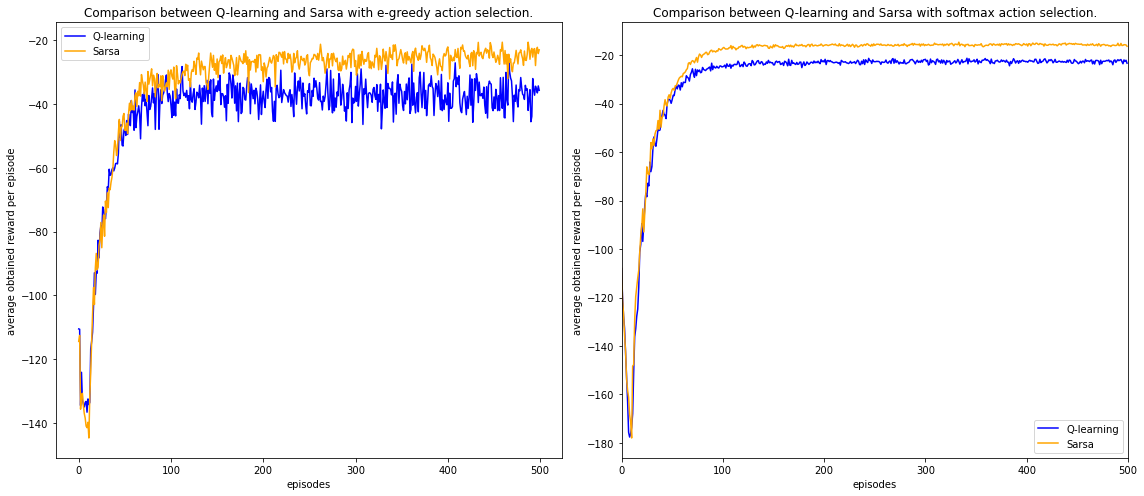

In [13]:
runs = 100   #this can take some minutes to run
QrunArrS, SrunArrS = [], []   #initialise arrays to hold the obtained rewards for all episodes per run (Softmax)
avgQrunS, avgSrunS = [], []   #initialise arrays to hold the average reward per episode averaged over all runs (Softmax)

for i in range(runs):
    QrewardArr, SrewardArr = [], []   #reset arrays to hold the obtained reward per episode
    QrewardArr = QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
    SrewardArr = Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
    QrunArrS.append(QrewardArr)
    SrunArrS.append(SrewardArr)

QrunArrS = np.array(QrunArrS)   #convert to numpy.array
SrunArrS = np.array(SrunArrS)

for i in range(episodes):
    avgQrunS.append(np.mean(QrunArrS[:,i]))   #calculate average reward per episode averaged over all runs (Softmax)
    avgSrunS.append(np.mean(SrunArrS[:,i]))

#generate two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 7))
p1, = ax1.plot(avgQrunE, color = "blue")
p2, = ax1.plot(avgSrunE, color = "orange")
p3, = ax2.plot(avgQrunS, color = "blue")
p4, = ax2.plot(avgSrunS, color = "orange")
plt.xlim([0, episodes])
ax1.set_title("Comparison between Q-learning and Sarsa with e-greedy action selection.")
ax1.set_xlabel("episodes")
ax1.set_ylabel("average obtained reward per episode")
ax1.legend([p1, p2], ["Q-learning", "Sarsa"])
ax2.set_title("Comparison between Q-learning and Sarsa with softmax action selection.")
ax2.set_xlabel("episodes")
ax2.set_ylabel("average obtained reward per episode")
ax2.legend([p3, p4], ["Q-learning", "Sarsa"])
plt.tight_layout()
#plt.savefig('Figure5.pdf') 
plt.show()

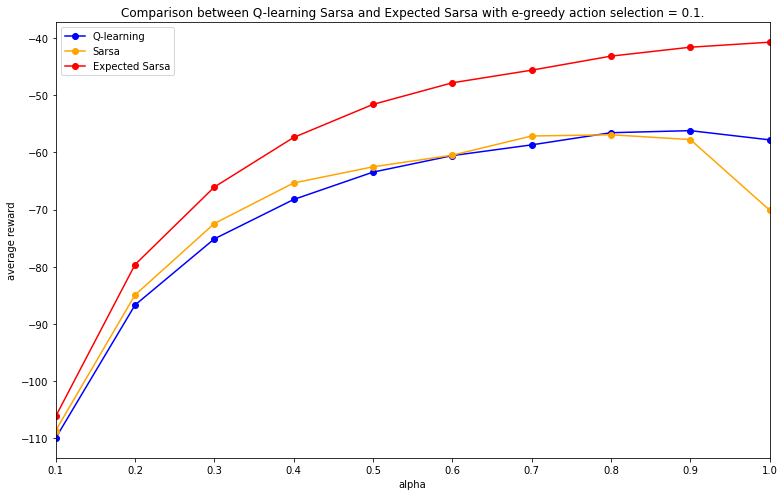

In [14]:
method = "egreedy"
episodes = 100
runs = 100   #this can take some minutes to run.

IPQ, IPS, IPES = [], [], []   #generate interim performance arrays to hold the mean reward per episode
IPQa, IPSa, IPESa = [], [], []   #generate interim performance arrays to hold the mean reward of each run
QrewardArr, SrewardArr, ESrewardArr = [], [], []   #generate arrays to hold the obtained reward per episode
aValues = [i/10 for i in range(1, 11)]   #generate the alpha values in range [0.1, 1.0] with steps of 0.1.

for a in aValues:   #loop over all the alpha values
    alpha = a
    IPQ, IPS, IPES = [], [], []   #reset arrays at the beginning of each new alpha value
    
    for i in range(runs):
        QrewardArr, SrewardArr, ESrewardArr = [], [], []   #reset the arrays for each run
        QrewardArr = QLearning(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
        SrewardArr = Sarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
        ESrewardArr = expectedSarsa(alpha, beta, gamma, epsilon, method, episodes, rows, columns, cliffWorld, actions)
        IPQ.append(np.mean(QrewardArr))   #calculate the mean of each run
        IPS.append(np.mean(SrewardArr))
        IPES.append(np.mean(ESrewardArr))
    IPQa.append(np.mean(IPQ))   #calculate the mean of all the runs
    IPSa.append(np.mean(IPS))
    IPESa.append(np.mean(IPES))

#Generate the figure
fig, (ax1) = plt.subplots(1,1, figsize = (11,7))
p1, = ax1.plot(aValues, IPQa, 'o-', color = "blue")
p2, = ax1.plot(aValues, IPSa, 'o-', color = "orange")
p3, = ax1.plot(aValues, IPESa, 'o-', color = "red")
plt.xlim([0.1, 1.0])
ax1.set_title("Comparison between Q-learning Sarsa and Expected Sarsa with e-greedy action selection = 0.1.")
ax1.set_xlabel("alpha")
ax1.set_ylabel("average reward")
ax1.legend([p1, p2, p3], ["Q-learning", "Sarsa", "Expected Sarsa"])
plt.tight_layout()
#plt.savefig('Figure6.pdf')
plt.show()